# Práctica 2 - SVM

## Funciones auxiliares
Primero, podemos crear algunas funciones auxiliares (como por ejemplo, para la transformación).

In [52]:
euclidean <- function(xp, xn) sqrt(sum((xp - xn)^2))

transformacion <- function(x1, x2) {
  len <- length(x1)
  for (i in 1:len) {
    if (sqrt(x1[i]^2 + x2[i]^2) > 2) {
      x1[i] <- 4 - x2[i] + abs(x1[i] - x2[i])
      x2[i] <- 4 - x1[i] + abs(x1[i] - x2[i])
    }
  }
  return(list(X1 = x2, X2 = x2))
}

print_clasificacion <- function(x, w, b) {
  print(x)
  if ((t(w) %*% x + b) >= 0) {
    print("Pertenece a la clase: 1")
  } else {
    print("Pertenece a la clase: -1")
  }
}

kernel <- function(x1, x2) {
  len_x1 <- length(x1)
  len_x2 <- length(x2)
  k <- matrix(data = NA, nrow = len_x1, ncol = len_x2)
  for (i in 1:len_x1) {
    xi <- c(x1[i], x2[i])
    for (j in 1:len_x2) {
      xj <- c(x1[j], x2[j])
      k[i, j] <- xi %*% xj
    }
  }
  return(k)
}

support_vectors <- function(x1_positive, x2_positive,
                            x1_negative, x2_negative) {
  len_positive <- length(x1_positive)
  len_negative <- length(x1_negative)
  svp <- NA
  svn <- NA
  min_dist <- Inf
  for (i in 1:len_positive) {
    xp <- c(x1_positive[i], x2_positive[i])
    for (j in 1:len_negative) {
      xn <- c(x1_negative[j], x2_negative[j])
      dist <- euclidean(xp, xn)
      if (dist < min_dist) {
        min_dist <- dist
        svp <- xp
        svn <- xn
      }
    }
  }
  return(list(SVP = svp,
              SVN = svn))
}

equations <- function(svp, svn) {
  eq_matrix <- rbind(c(1, -1, 0),
                     c((svp %*% svp), -1 * (svn %*% svp), 1),
                     c((svp %*% svn), -1 * (svn %*% svn), 1))
  sol_matrix <- c(0, 1, -1)
  return(solve(eq_matrix, sol_matrix))
}

weights_vector <- function(coefs, svp, svn) {
  w <- coefs[1] * svp - coefs[2] * svn
  return(w)
}

road_width <- function(weights) {
  denom <- sqrt((weights[1])^2 + (weights[2])^2)
  return(2 / denom)
}

manual_svm <- function(svp, svn, weights, width, k, coefs) {
  weights_rho <- c(paste(c(weights[2]), collapse = " "),
                   paste(c(coefs[3]), collapse = " "))
  if (weights[2] >= 0) {
    weights_rho[1] <- paste(c("+", weights[2]), collapse = " ")
  }
  if (coefs[3] >= 0) {
    weights_rho[2] <- paste(c("+", coefs[3]), collapse = " ")
  }
  hyperplane <- paste(c(weights[1], "* x ", weights_rho[1],
                        "* y", weights_rho[2], " = 0"), collapse = " ")
  p_hyperplane <- paste(c(weights[1], "* x ", weights_rho[1],
                          "* y", weights_rho[2], " = 1"), collapse = " ")
  n_hyperplane <- paste(c(weights[1], "* x ", weights_rho[1],
                          "* y", weights_rho[2], " = -1"), collapse = " ")
  return(list(SVP = data.frame(X1 = svp[1], X2 = svp[2]),
              SVN = data.frame(X1 = svn[1], X2 = svn[2]),
              W = data.frame(X1 = weights[1], X2 = weights[2]),
              width = width,
              K = k,
              alpha_1 = coefs[1],
              alpha_2 = coefs[2],
              rho = coefs[3],
              planes = data.frame(hyperplane = hyperplane,
                                  positive_support = p_hyperplane,
                                  negative_support = n_hyperplane)))
}

## Librerías y dataframes
Una vez creadas las funciones auxiliares, cargamos las librerías necesarias y creamos los dataframes a usar, poniendo la columna Y de cada uno como factor.

In [3]:
library(tidyverse)

dataframe_a <- data.frame(X1 = c(0, 4), X2 = c(0, 4), Y = c(1, -1))
dataframe_a$Y <- as.factor(dataframe_a$Y)
dataframe_a

dataframe_b <- data.frame(X1 = c(2, 0, 1), X2 = c(0, 0, 1), Y = c(1, -1, -1))
dataframe_b$Y <- as.factor(dataframe_b$Y)
dataframe_b

dataframe_c <- data.frame(X1 = c(2, 2, -2, -2, 1, 1, -1, -1),
                          X2 = c(2, -2, -2, 2, 1, -1, -1, 1),
                          Y = c(rep(1, 4), rep(-1, 4)))
dataframe_c$Y <- as.factor(dataframe_c$Y)
dataframe_c

dataframe_d <- dataframe_c
x1_x2 <- transformacion(dataframe_d$X1, dataframe_d$X2)
dataframe_d$X1 <- x1_x2$X1
dataframe_d$X2 <- x1_x2$X2
dataframe_d

dataframe_e <- data.frame(X1 = c(3, 3, 6, 6, 1, 0, 0, -1),
                          X2 = c(1, -1, 1, -1, 0, 1, -1, 0),
                          Y = c(rep(1, 4), rep(-1, 4)))
dataframe_e$Y <- as.factor(dataframe_e$Y)
dataframe_e

X1,X2,Y
<dbl>,<dbl>,<fct>
0,0,1
4,4,-1


X1,X2,Y
<dbl>,<dbl>,<fct>
2,0,1
0,0,-1
1,1,-1


X1,X2,Y
<dbl>,<dbl>,<fct>
2,2,1
2,-2,1
-2,-2,1
-2,2,1
1,1,-1
1,-1,-1
-1,-1,-1
-1,1,-1


X1,X2,Y
<dbl>,<dbl>,<fct>
2,2,1
6,6,1
6,6,1
2,2,1
1,1,-1
-1,-1,-1
-1,-1,-1
1,1,-1


X1,X2,Y
<dbl>,<dbl>,<fct>
3,1,1
3,-1,1
6,1,1
6,-1,1
1,0,-1
0,1,-1
0,-1,-1
-1,0,-1


## Desarrollo
Primero, determinamos los vectores soporte de cada dataframe

In [43]:
dataframe_a_positive <- as.vector(dataframe_a[dataframe_a$Y == 1, -3])
dataframe_a_negative <- as.vector(dataframe_a[dataframe_a$Y == -1, -3])
sv_df_a <- support_vectors(dataframe_a_positive[[1]], dataframe_a_positive[[2]],
                           dataframe_a_negative[[1]], dataframe_a_negative[[2]])
sv_df_a
dataframe_b_positive <- as.vector(dataframe_b[dataframe_b$Y == 1, -3])
dataframe_b_negative <- as.vector(dataframe_b[dataframe_b$Y == -1, -3])
sv_df_b <- support_vectors(dataframe_b_positive[[1]], dataframe_b_positive[[2]],
                           dataframe_b_negative[[1]], dataframe_b_negative[[2]])
sv_df_b
dataframe_c_positive <- as.vector(dataframe_c[dataframe_c$Y == 1, -3])
dataframe_c_negative <- as.vector(dataframe_c[dataframe_c$Y == -1, -3])
sv_df_c <- support_vectors(dataframe_c_positive[[1]], dataframe_c_positive[[2]],
                           dataframe_c_negative[[1]], dataframe_c_negative[[2]])
sv_df_c
dataframe_d_positive <- as.vector(dataframe_d[dataframe_d$Y == 1, -3])
dataframe_d_negative <- as.vector(dataframe_d[dataframe_d$Y == -1, -3])
sv_df_d <- support_vectors(dataframe_d_positive[[1]], dataframe_d_positive[[2]],
                           dataframe_d_negative[[1]], dataframe_d_negative[[2]])
sv_df_d
dataframe_e_positive <- as.vector(dataframe_e[dataframe_e$Y == 1, -3])
dataframe_e_negative <- as.vector(dataframe_e[dataframe_e$Y == -1, -3])
sv_df_e <- support_vectors(dataframe_e_positive[[1]], dataframe_e_positive[[2]],
                           dataframe_e_negative[[1]], dataframe_e_negative[[2]])
sv_df_e

$SVP
[1] 0 0

$SVN
[1] 4 4

$SVP
[1] 2 0

$SVN
[1] 1 1

$SVP
[1] 2 2

$SVN
[1] 1 1

$SVP
[1] 2 2

$SVN
[1] 1 1

$SVP
[1] 3 1

$SVN
[1] 1 0

Para calcular los kernels, podemos usar nuestra función auxiliar *kernel*

In [14]:
kernel_df_a <- kernel(dataframe_a$X1, dataframe_a$X2)
kernel_df_a
kernel_df_b <- kernel(dataframe_b$X1, dataframe_b$X2)
kernel_df_b
kernel_df_c <- kernel(dataframe_c$X1, dataframe_c$X2)
kernel_df_c
kernel_df_d <- kernel(dataframe_d$X1, dataframe_d$X2)
kernel_df_d
kernel_df_e <- kernel(dataframe_e$X1, dataframe_e$X2)
kernel_df_e

0,0
0,32


4,0,2
0,0,0
2,0,2


8,0,-8,0,4,0,-4,0
0,8,0,-8,0,4,0,-4
-8,0,8,0,-4,0,4,0
0,-8,0,8,0,-4,0,4
4,0,-4,0,2,0,-2,0
0,4,0,-4,0,2,0,-2
-4,0,4,0,-2,0,2,0
0,-4,0,4,0,-2,0,2


8,24,24,8,4,-4,-4,4
24,72,72,24,12,-12,-12,12
24,72,72,24,12,-12,-12,12
8,24,24,8,4,-4,-4,4
4,12,12,4,2,-2,-2,2
-4,-12,-12,-4,-2,2,2,-2
-4,-12,-12,-4,-2,2,2,-2
4,12,12,4,2,-2,-2,2


10,8,19,17,3,1,-1,-3
8,10,17,19,3,-1,1,-3
19,17,37,35,6,1,-1,-6
17,19,35,37,6,-1,1,-6
3,3,6,6,1,0,0,-1
1,-1,1,-1,0,1,-1,0
-1,1,-1,1,0,-1,1,0
-3,-3,-6,-6,-1,0,0,1


Para determinar los coeficientes de cada máquina vector soporte, tenemos que plantear y resolver las ecuaciones, usando nuestra función auxiliar *equations*

In [32]:
coefs_df_a <- equations(sv_df_a$SVP, sv_df_a$SVN)
coefs_df_a
coefs_df_b <- equations(sv_df_b$SVP, sv_df_b$SVN)
coefs_df_b
coefs_df_c <- equations(sv_df_c$SVP, sv_df_c$SVN)
coefs_df_c
coefs_df_d <- equations(sv_df_d$SVP, sv_df_d$SVN)
coefs_df_d
coefs_df_e <- equations(sv_df_e$SVP, sv_df_e$SVN)
coefs_df_e

[1] 0.0625 0.0625 1.0000

[1]  1  1 -1

[1]  1  1 -3

[1]  1  1 -3

[1]  0.4  0.4 -1.8

Una vez tenemos los coeficientes, podemos calcular los vectores de pesos de cada máquina.

In [38]:
w_df_a <- weights_vector(coefs_df_a, sv_df_a$SVP, sv_df_a$SVN)
w_df_a
w_df_b <- weights_vector(coefs_df_b, sv_df_b$SVP, sv_df_b$SVN)
w_df_b
w_df_c <- weights_vector(coefs_df_c, sv_df_c$SVP, sv_df_c$SVN)
w_df_c
w_df_d <- weights_vector(coefs_df_d, sv_df_d$SVP, sv_df_d$SVN)
w_df_d
w_df_e <- weights_vector(coefs_df_e, sv_df_e$SVP, sv_df_e$SVN)
w_df_e

[1] -0.25 -0.25

[1]  1 -1

[1] 1 1

[1] 1 1

[1] 0.8 0.4

Teniendo los vectores de pesos, podemos obtener el ancho del canal de cada máquina

In [42]:
width_df_a <- road_width(w_df_a)
width_df_a
width_df_b <- road_width(w_df_b)
width_df_b
width_df_c <- road_width(w_df_c)
width_df_c
width_df_d <- road_width(w_df_d)
width_df_d
width_df_e <- road_width(w_df_e)
width_df_e

[1] 5.656854

[1] 1.414214

[1] 1.414214

[1] 1.414214

[1] 2.236068

Con todo lo obtenido anteriormente, podemos crear nuestras máquinas vector soporte con la función *manual_svm*

In [53]:
svm_df_a <- manual_svm(sv_df_a$SVP, sv_df_a$SVN, w_df_a,
                       width_df_a, kernel_df_a, coefs_df_a)
svm_df_a
svm_df_b <- manual_svm(sv_df_b$SVP, sv_df_b$SVN, w_df_b,
                       width_df_b, kernel_df_b, coefs_df_b)
svm_df_b
svm_df_c <- manual_svm(sv_df_c$SVP, sv_df_c$SVN, w_df_c,
                       width_df_c, kernel_df_c, coefs_df_c)
svm_df_c
svm_df_d <- manual_svm(sv_df_d$SVP, sv_df_d$SVN, w_df_d,
                       width_df_d, kernel_df_d, coefs_df_d)
svm_df_d
svm_df_e <- manual_svm(sv_df_e$SVP, sv_df_e$SVN, w_df_e,
                       width_df_e, kernel_df_e, coefs_df_e)
svm_df_e

X1,X2
<dbl>,<dbl>
0,0
X1,X2
<dbl>,<dbl>
4,4
X1,X2
<dbl>,<dbl>
-0.25,-0.25
0,0
0,32


$SVP
  X1 X2
1  2  0

$SVN
  X1 X2
1  1  1

$W
  X1 X2
1  1 -1

$width
[1] 1.414214

$K
     [,1] [,2] [,3]
[1,]    4    0    2
[2,]    0    0    0
[3,]    2    0    2

$alpha_1
[1] 1

$alpha_2
[1] 1

$rho
[1] -1

$planes
             hyperplane      positive_support       negative_support
1 1 * x  -1 * y -1  = 0 1 * x  -1 * y -1  = 1 1 * x  -1 * y -1  = -1

$SVP
  X1 X2
1  2  2

$SVN
  X1 X2
1  1  1

$W
  X1 X2
1  1  1

$width
[1] 1.414214

$K
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    8    0   -8    0    4    0   -4    0
[2,]    0    8    0   -8    0    4    0   -4
[3,]   -8    0    8    0   -4    0    4    0
[4,]    0   -8    0    8    0   -4    0    4
[5,]    4    0   -4    0    2    0   -2    0
[6,]    0    4    0   -4    0    2    0   -2
[7,]   -4    0    4    0   -2    0    2    0
[8,]    0   -4    0    4    0   -2    0    2

$alpha_1
[1] 1

$alpha_2
[1] 1

$rho
[1] -3

$planes
              hyperplane       positive_support        negative_support
1 1 * x  + 1 * y -3  = 0 1 * x  + 1 * y -3  = 1 1 * x  + 1 * y -3  = -1

$SVP
  X1 X2
1  2  2

$SVN
  X1 X2
1  1  1

$W
  X1 X2
1  1  1

$width
[1] 1.414214

$K
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    8   24   24    8    4   -4   -4    4
[2,]   24   72   72   24   12  -12  -12   12
[3,]   24   72   72   24   12  -12  -12   12
[4,]    8   24   24    8    4   -4   -4    4
[5,]    4   12   12    4    2   -2   -2    2
[6,]   -4  -12  -12   -4   -2    2    2   -2
[7,]   -4  -12  -12   -4   -2    2    2   -2
[8,]    4   12   12    4    2   -2   -2    2

$alpha_1
[1] 1

$alpha_2
[1] 1

$rho
[1] -3

$planes
              hyperplane       positive_support        negative_support
1 1 * x  + 1 * y -3  = 0 1 * x  + 1 * y -3  = 1 1 * x  + 1 * y -3  = -1

$SVP
  X1 X2
1  3  1

$SVN
  X1 X2
1  1  0

$W
   X1  X2
1 0.8 0.4

$width
[1] 2.236068

$K
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]   10    8   19   17    3    1   -1   -3
[2,]    8   10   17   19    3   -1    1   -3
[3,]   19   17   37   35    6    1   -1   -6
[4,]   17   19   35   37    6   -1    1   -6
[5,]    3    3    6    6    1    0    0   -1
[6,]    1   -1    1   -1    0    1   -1    0
[7,]   -1    1   -1    1    0   -1    1    0
[8,]   -3   -3   -6   -6   -1    0    0    1

$alpha_1
[1] 0.4

$alpha_2
[1] 0.4

$rho
[1] -1.8

$planes
                    hyperplane             positive_support
1 0.8 * x  + 0.4 * y -1.8  = 0 0.8 * x  + 0.4 * y -1.8  = 1
               negative_support
1 0.8 * x  + 0.4 * y -1.8  = -1

Y con esto, podemos dibujar los puntos y planos

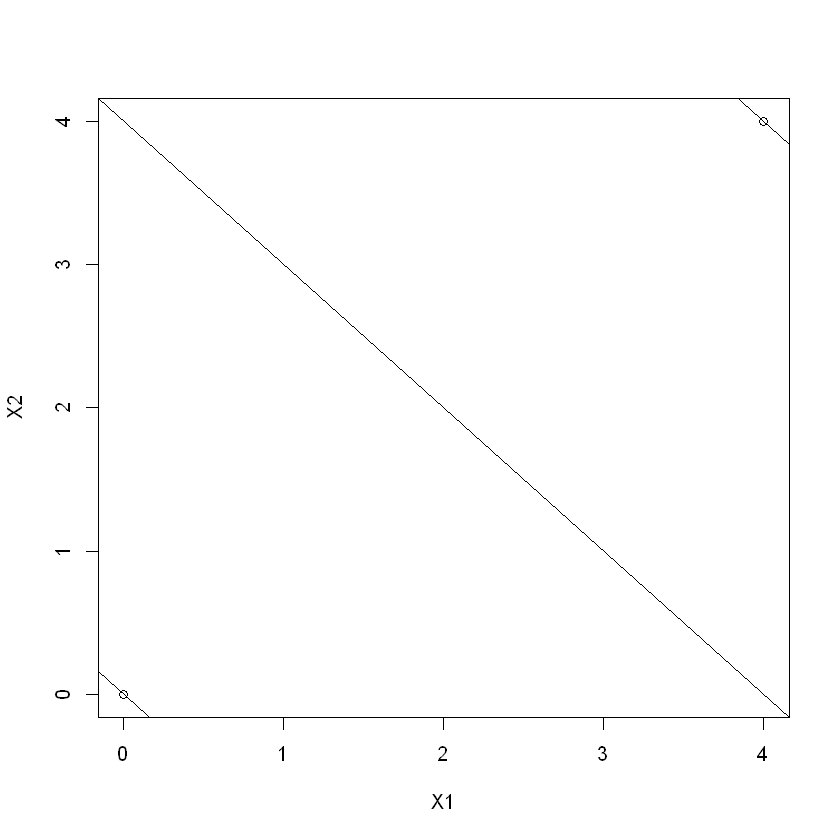

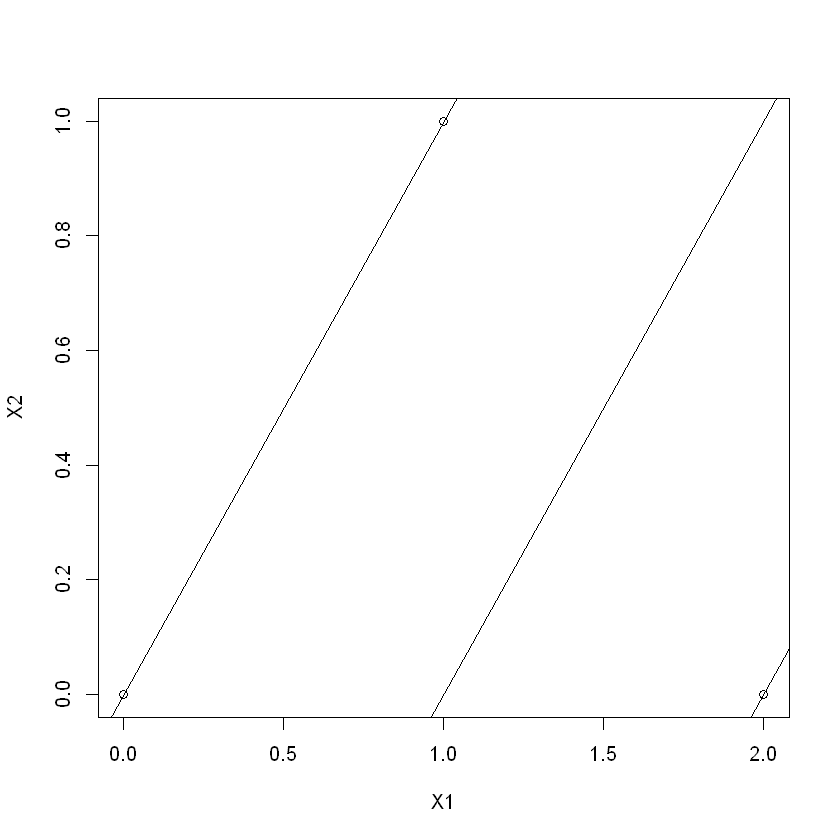

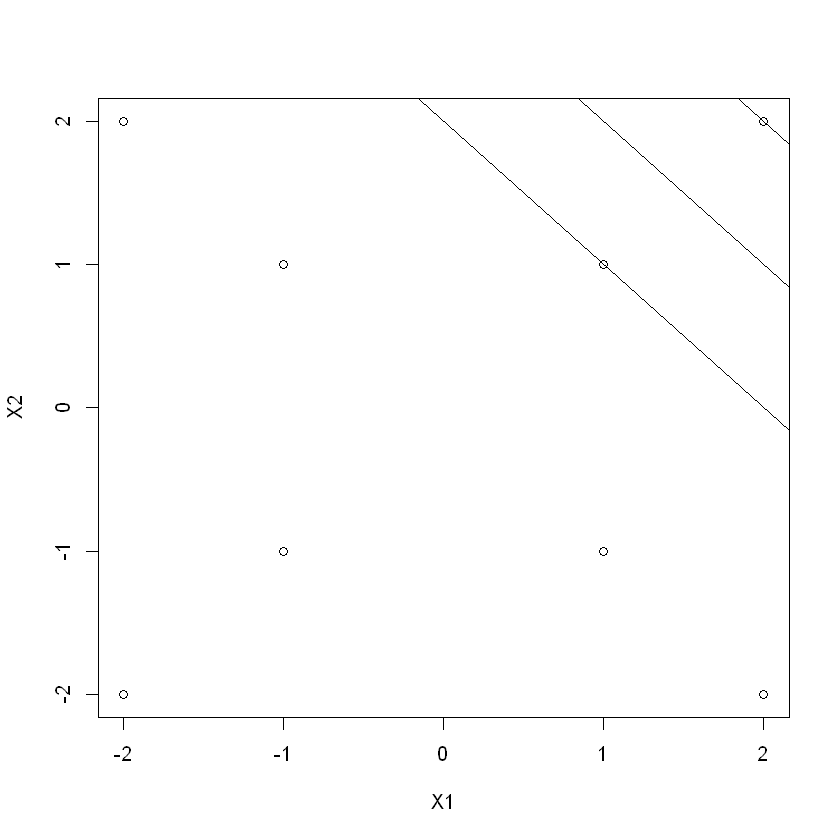

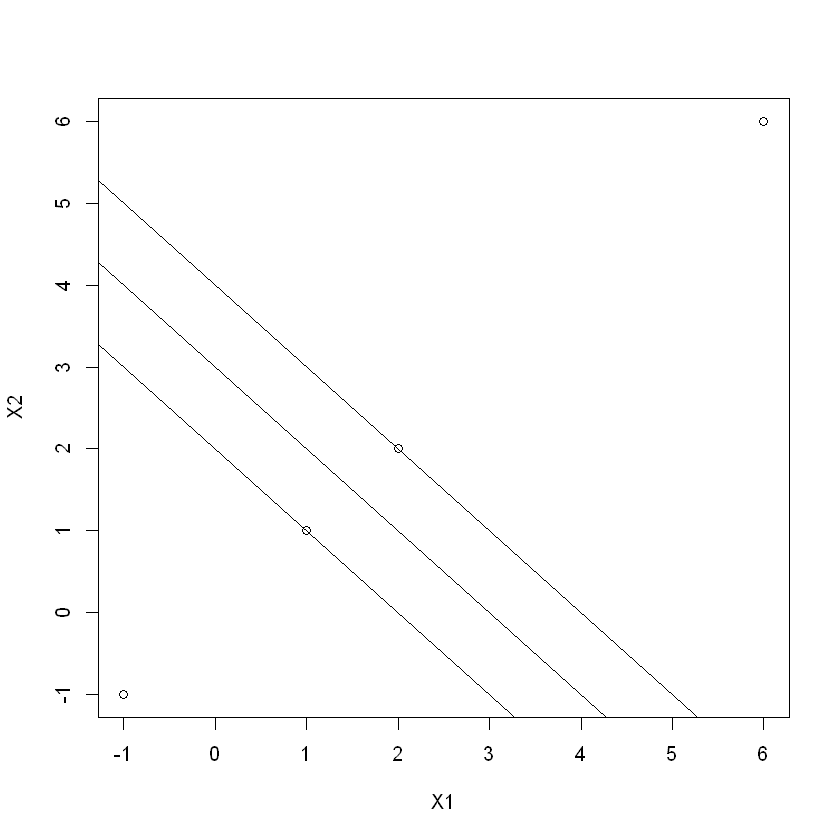

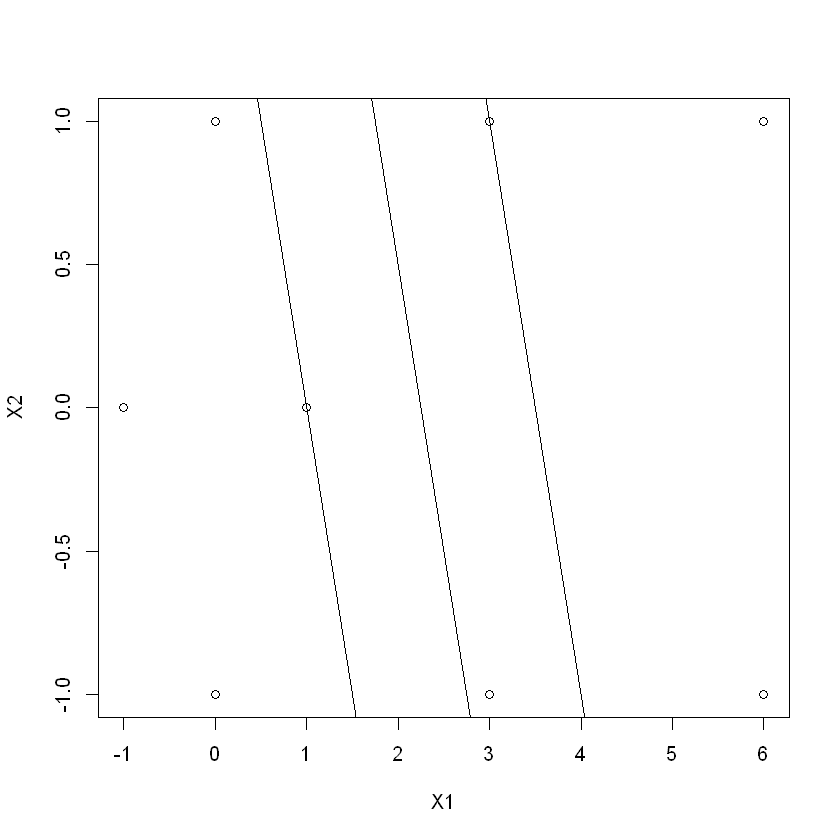

In [58]:
plot(dataframe_a$X1, dataframe_a$X2, xlab = "X1", ylab = "X2")
abline(- coefs_df_a[3] / w_df_a[2], -w_df_a[1] / w_df_a[2])
abline((1 - coefs_df_a[3]) / w_df_a[2], -w_df_a[1] / w_df_a[2])
abline((-1 - coefs_df_a[3]) / w_df_a[2], -w_df_a[1] / w_df_a[2])
plot(dataframe_b$X1, dataframe_b$X2, xlab = "X1", ylab = "X2")
abline(- coefs_df_b[3] / w_df_b[2], -w_df_b[1] / w_df_b[2])
abline((1 - coefs_df_b[3]) / w_df_b[2], -w_df_b[1] / w_df_b[2])
abline((-1 - coefs_df_b[3]) / w_df_b[2], -w_df_b[1] / w_df_b[2])
plot(dataframe_c$X1, dataframe_c$X2, xlab = "X1", ylab = "X2")
abline(- coefs_df_c[3] / w_df_c[2], -w_df_c[1] / w_df_c[2])
abline((1 - coefs_df_c[3]) / w_df_c[2], -w_df_c[1] / w_df_c[2])
abline((-1 - coefs_df_c[3]) / w_df_c[2], -w_df_c[1] / w_df_c[2])
plot(dataframe_d$X1, dataframe_d$X2, xlab = "X1", ylab = "X2")
abline(- coefs_df_d[3] / w_df_d[2], -w_df_d[1] / w_df_d[2])
abline((1 - coefs_df_d[3]) / w_df_d[2], -w_df_d[1] / w_df_d[2])
abline((-1 - coefs_df_d[3]) / w_df_d[2], -w_df_d[1] / w_df_d[2])
plot(dataframe_e$X1, dataframe_e$X2, xlab = "X1", ylab = "X2")
abline(- coefs_df_e[3] / w_df_e[2], -w_df_e[1] / w_df_e[2])
abline((1 - coefs_df_e[3]) / w_df_e[2], -w_df_e[1] / w_df_e[2])
abline((-1 - coefs_df_e[3]) / w_df_e[2], -w_df_e[1] / w_df_e[2])